In [1]:
import gc
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np

# builder modules
import builders
import builders_rwx

# solver modules
from classic_solvers import *
import lp_solvers
import lp_solvers_rwx

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def gen_graphs(graph_dir, n_vals, graph_params, K=5, S=5):
    os.makedirs(graph_dir, exist_ok=True)

    # Metadata to be saved separately
    metadata = {
        "n_vals": n_vals,
        "graph_params": graph_params,
        "graph_files": [],
    }

    for n in n_vals:
        # Directory to store graphs for this specific `n`
        n_dir = os.path.join(graph_dir, f"n_{n}")
        os.makedirs(n_dir, exist_ok=True)

        for idx in range(K):
            # Build the graph
            G = builders.gen_graph(graph_params, n)

            # Sample source-sink pairs
            source_sink_pairs = builders.sample_node_pairs(G, S)

            # Prepare data for this graph
            graph_data = {
                "graph": G,
                "source_sink_pairs": source_sink_pairs,
            }

            # Save each graph individually
            graph_file = os.path.join(n_dir, f"graph_{idx}.pkl")
            with open(graph_file, 'wb') as file:
                pickle.dump(graph_data, file)

            # Add to metadata
            metadata["graph_files"].append(graph_file)

            del G
            gc.collect()

    # Save metadata
    metadata_file = os.path.join(graph_dir, "metadata.pkl")
    with open(metadata_file, 'wb') as file:
        pickle.dump(metadata, file)

    print(f"Graphs saved to {graph_dir}")

In [18]:
graphs_folder = 'graphs'
n_vals = list(map(int, np.logspace(np.log10(10), np.log10(1000), 10)))
print(n_vals)

# List of parameter dictionaries
param_dicts = [
    {'type': 'complete'},
    {'type': 'tree'},
    {'type': 'erdos-renyi', 'p': 0.01},
    {'type': 'barabasi-albert', 'm': 2},
]

# Loop through parameter dictionaries and run the generate_graphs function
for params in param_dicts:
    gen_graphs(os.path.join(graphs_folder, params['type']), n_vals, params, K=5, S=10)


[10, 16, 27, 46, 77, 129, 215, 359, 599, 1000]
Graphs saved to graphs/complete
Graphs saved to graphs/tree
Graphs saved to graphs/erdos-renyi
Graphs saved to graphs/barabasi-albert


In [4]:
def run_solvers_granular(methods, graph_dir):
    # Load metadata
    metadata_file = os.path.join(graph_dir, "metadata.pkl")
    with open(metadata_file, 'rb') as file:
        metadata = pickle.load(file)

    n_vals = metadata['n_vals']
    graph_files = metadata['graph_files']
    graph_files_by_n = {}

    # Organize graph files by their respective n values
    for graph_file in graph_files:
        n = int(os.path.basename(os.path.dirname(graph_file)).split('_')[1])
        graph_files_by_n.setdefault(n, []).append(graph_file)

    # Initialize average runtimes
    average_runtimes = {method_name: [] for _, method_name in methods}
    print(f"Beginning solves for {graph_dir}")
    for n in n_vals:
        print(f"Processing solves for n={n}")
        runtimes_at_current_size = {method_name: [] for _, method_name in methods}

        # Process each graph file for the current n
        for graph_file in graph_files_by_n.get(n, []):
            with open(graph_file, 'rb') as file:
                graph_data = pickle.load(file)

            G = graph_data['graph']
            ss_pairs = graph_data['source_sink_pairs']
            runtimes_in_current_graph = {method_name: [] for _, method_name in methods}

            for s, t in ss_pairs:
                for method, method_name in methods:
                    sol = method(G, s, t)
                    # print("solved")
                    runtimes_in_current_graph[method_name].append(sol['run_time'])

            for method_name in runtimes_in_current_graph:
                avg_runtime = sum(runtimes_in_current_graph[method_name]) / len(runtimes_in_current_graph[method_name])
                runtimes_at_current_size[method_name].append(avg_runtime)

        for method_name in runtimes_at_current_size:
            if runtimes_at_current_size[method_name]:  # Avoid division by zero
                avg_runtime_over_graphs = sum(runtimes_at_current_size[method_name]) / len(
                    runtimes_at_current_size[method_name])
                average_runtimes[method_name].append(avg_runtime_over_graphs)
            else:
                average_runtimes[method_name].append(0)

    # Plot the results
    plt.figure(figsize=(10, 6))
    for method_name in average_runtimes:
        plt.plot(n_vals, average_runtimes[method_name], marker='o', label=method_name)

    plt.xlabel('Number of Nodes (n)')
    plt.ylabel('Average Runtime (seconds)')
    plt.title(f"Average Max-Flow Computation Time vs. Graph Size ({metadata['graph_params']['type']})")
    plt.legend()
    plt.grid(True)
    plt.show()

Beginning solves for ./graphs/barabasi-albert
Processing solves for n=10
Processing solves for n=16
Processing solves for n=27
Processing solves for n=46
Processing solves for n=77
Processing solves for n=129
Processing solves for n=215
Processing solves for n=359
Processing solves for n=599
Processing solves for n=1000


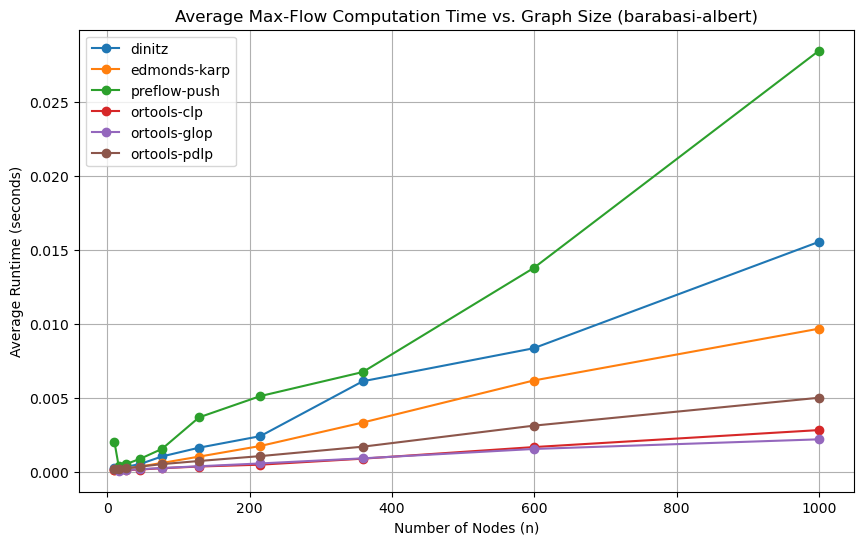

In [8]:
methods = [
    (max_flow_dinitz, 'dinitz'),
    (max_flow_edmonds_karp, 'edmonds-karp'),
    (max_flow_preflow_push, 'preflow-push'),
    (lp_solvers.max_flow_ortools_CLP, 'ortools-clp'),
    (lp_solvers.max_flow_ortools_GLOP, 'ortools-glop'),
    (lp_solvers.max_flow_ortools_PDLP, 'ortools-pdlp'),
    # (lp_solvers.max_flow_pulp_GLPK_primal, 'pulp-glpk-primal'),
    # (lp_solvers.max_flow_pulp_GLPK_dual, 'pulp-glpk-dual'),
    # (lp_solvers.max_flow_pulp_GLPK_barrier, 'pulp-glpk-barrier')
]

run_solvers_granular(methods, "./graphs/barabasi-albert")

Beginning solves for ./graphs/barabasi-albert
Processing solves for n=10
Processing solves for n=16
Processing solves for n=27
Processing solves for n=46
Processing solves for n=77
Processing solves for n=129
Processing solves for n=215
Processing solves for n=359
Processing solves for n=599
Processing solves for n=1000


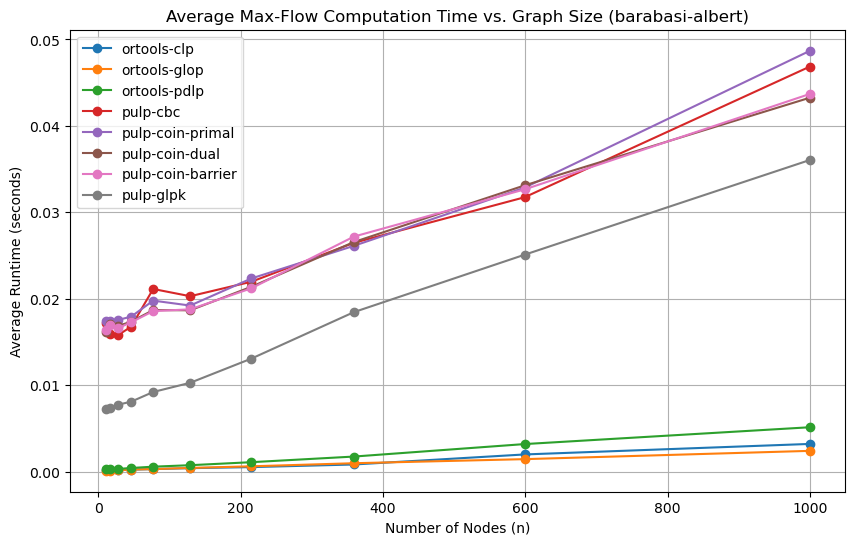

In [18]:
methods = [
    # (max_flow_dinitz, 'dinitz'),
    # (max_flow_edmonds_karp, 'edmonds-karp'),
    # (max_flow_preflow_push, 'preflow-push'),
    (lp_solvers.max_flow_ortools_CLP, 'ortools-clp'),
    (lp_solvers.max_flow_ortools_GLOP, 'ortools-glop'),
    (lp_solvers.max_flow_ortools_PDLP, 'ortools-pdlp'),
    (lp_solvers.max_flow_pulp_CBC, 'pulp-cbc'),
    (lp_solvers.max_flow_pulp_COIN_primal, 'pulp-coin-primal'),
    (lp_solvers.max_flow_pulp_COIN_dual, 'pulp-coin-dual'),
    (lp_solvers.max_flow_pulp_COIN_barrier, 'pulp-coin-barrier'),
    (lp_solvers.max_flow_pulp_GLPK, 'pulp-glpk')
]

run_solvers_granular(methods, "./graphs/barabasi-albert")

Beginning solves for ./graphs/barabasi-albert
Processing solves for n=10
Processing solves for n=16
Processing solves for n=27
Processing solves for n=46
Processing solves for n=77
Processing solves for n=129
Processing solves for n=215
Processing solves for n=359
Processing solves for n=599
Processing solves for n=1000


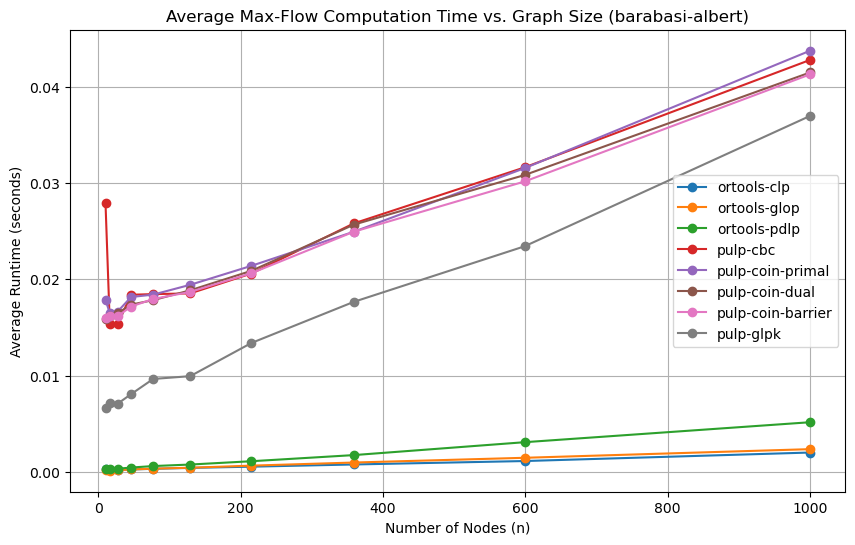

In [5]:
methods = [
    # (max_flow_dinitz, 'dinitz'),
    # (max_flow_edmonds_karp, 'edmonds-karp'),
    # (max_flow_preflow_push, 'preflow-push'),
    (lp_solvers.max_flow_ortools_CLP, 'ortools-clp'),
    (lp_solvers.max_flow_ortools_GLOP, 'ortools-glop'),
    (lp_solvers.max_flow_ortools_PDLP, 'ortools-pdlp'),
    (lp_solvers.max_flow_pulp_CBC, 'pulp-cbc'),
    (lp_solvers.max_flow_pulp_COIN_primal, 'pulp-coin-primal'),
    (lp_solvers.max_flow_pulp_COIN_dual, 'pulp-coin-dual'),
    (lp_solvers.max_flow_pulp_COIN_barrier, 'pulp-coin-barrier'),
    (lp_solvers.max_flow_pulp_GLPK, 'pulp-glpk')
]

run_solvers_granular(methods, "./graphs/barabasi-albert")